In [34]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

IN_A = Path("input_pca_set_A_.csv")
IN_B = Path("input_pca_set_B_.csv")
OUT_CSV = Path("comparative_cumulative_scree_values.csv")
OUT_PNG = Path("comparative_cumulative_scree.png")
OUT_PDF = Path("comparative_cumulative_scree.pdf")

K = 10   
YMIN = 50
TITLE = "Comparative Scree"

In [35]:
try:
    import seaborn as sns  # type: ignore
    sns.set_theme(style="whitegrid", context="talk")
except Exception:
    pass

In [36]:
def load_numeric_matrix(path: Path) -> np.ndarray:
    """Load CSV and return only numeric columns as a 2D numpy array with rows containing NaNs dropped."""
    df = pd.read_csv(path)
    num = df.select_dtypes(include=[np.number]).dropna(axis=0, how="any")
    return num.values

In [37]:
def pca_evr_sklearn(X: np.ndarray) -> np.ndarray:
    """Explained variance ratio via scikit-learn PCA."""
    # Use all possible components up to min(n_samples, n_features)
    ncomp = min(X.shape[0], X.shape[1])
    pca = PCA(n_components=ncomp, svd_solver="full")
    pca.fit(X)  # inputs are standardized already; PCA will center again
    return pca.explained_variance_ratio_

In [38]:
def cumulative_first_k(evr: np.ndarray, k: int) -> np.ndarray:
    """Cumulative EVR for the first k PCs, padded with the last value if fewer PCs exist."""
    c = np.cumsum(evr)
    if len(c) >= k:
        return c[:k]
    if len(c) == 0:
        return np.zeros(k)
    return np.concatenate([c, np.full(k - len(c), c[-1])])

In [39]:
Xa = load_numeric_matrix(IN_A)
Xb = load_numeric_matrix(IN_B)

evr_a = pca_evr_sklearn(Xa)
evr_b = pca_evr_sklearn(Xb)

cum_a = cumulative_first_k(evr_a, K) * 100.0
cum_b = cumulative_first_k(evr_b, K) * 100.0

index = [f"PC{i}" for i in range(1, K + 1)]
cum_df = pd.DataFrame(
    {
        "Set A cumulative variance (%)": np.round(cum_a, 2),
        "Set B cumulative variance (%)": np.round(cum_b, 2),
    },
    index=index,
)
cum_df.to_csv(OUT_CSV, index_label="PC")

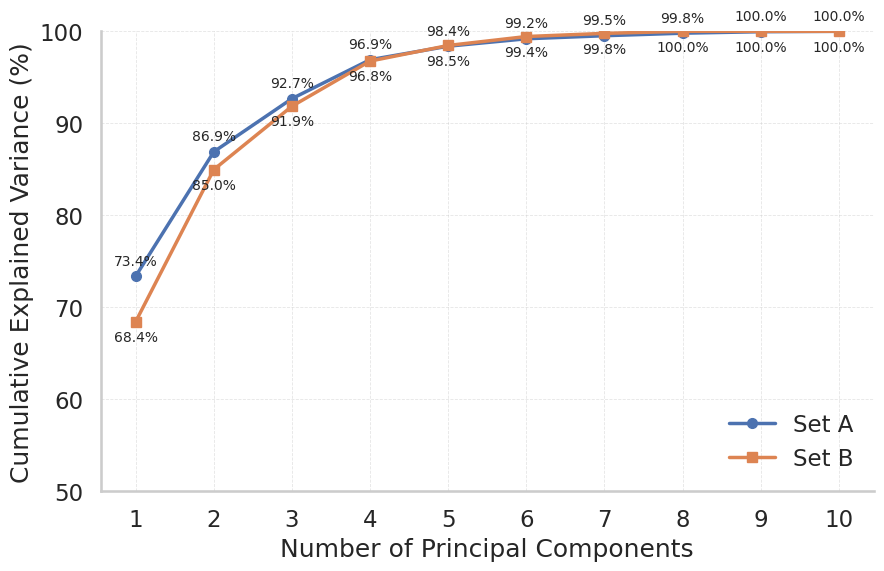

In [40]:
x = np.arange(1, K + 1)

plt.rcParams.update(
    {
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "font.size": 12,
    }
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(x, cum_a, marker="o", linewidth=2.5, markersize=7, label="Set A")
ax.plot(x, cum_b, marker="s", linewidth=2.5, markersize=7, label="Set B")

for xi, ya, yb in zip(x, cum_a, cum_b):
    ax.text(xi, ya + 0.9, f"{ya:.1f}%", ha="center", va="bottom", fontsize=10)
    ax.text(xi, yb - 0.9, f"{yb:.1f}%", ha="center", va="top", fontsize=10)

# Title moved up by exactly 1 mm (1 mm = 72/25.4 points)
MM_TO_PT = 72.0 / 25.4
base_pad = plt.rcParams.get("axes.titlepad", 6.0)
#ax.set_title(TITLE, pad=base_pad + MM_TO_PT)

ax.set_xlabel("Number of Principal Components")
ax.set_ylabel("Cumulative Explained Variance (%)")
ax.set_xticks(x)
ax.set_ylim(YMIN, 100)
ax.legend(frameon=False, loc="lower right")

fig.tight_layout(rect=(0, 0, 1, 0.98))  
fig.savefig(OUT_PNG, dpi=200)
plt.show()
plt.close(fig)

In [41]:
print(f"Saved CSV -> {OUT_CSV.resolve()}")
print(f"Saved plot -> {OUT_PNG.resolve()}")

Saved CSV -> /home/max/gits/pca-notebook/comparative_cumulative_scree_values.csv
Saved plot -> /home/max/gits/pca-notebook/comparative_cumulative_scree.png
